<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/ASSIGNMENT7/IDL_ASSIGNMENT_7_Govind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team


1.   Govind Shukla (235192)
2.   Meghana Rao (234907)
3.   Srinath Mannam (229750)

#Imports

In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text
import pathlib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
use_builtins = True
DATA_FILE_PATH = '/content/drive/MyDrive/IDL_Lecture/data/ita-eng/ita.txt'

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#Data loading

In [ ]:
def load_data(path):
  text = pathlib.Path(path).read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp, attr in pairs]
  targ = [targ for targ, inp, attr in pairs]

  return targ, inp

In [ ]:
targ, inp = load_data(DATA_FILE_PATH)
print(inp[-1])
print(targ[-1])

Senza dubbio esiste in questo mondo proprio la donna giusta per ogni uomo da sposare e viceversa; ma se si considera che un essere umano ha l'opportunità di conoscere solo poche centinaia di persone, e fra le poche centinaia che ce ne sono solo una dozzina o meno che conosce intimamente e fra la dozzina, uno o due amici al massimo, si vedrà facilmente, quando ricorderemo il numero di milioni che abitano questo mondo, che probabilmente, da quando è stata creata la terra, l'uomo giusto non ha mai incontrato la donna giusta.
Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the ea

#Data Preprocessing

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.take(500)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:10])
  print()
  print(example_target_batch[:10])
  break


tf.Tensor(
[b"Tom mi ha vista dare un po' di denaro a Mary."
 b"C'\xc3\xa8 qualcosa che volete dirmi?"
 b'Tom ha lavorato con i cavalli tutto il giorno.'
 b'I suoi disegni sono molto originali.'
 b'Perch\xc3\xa9 non sta prendendo appunti?'
 b'Tu hai un libro da leggere?' b'Ha tirato fuori qualcosa dalla borsa.'
 b'Sono quasi pronta.' b'Ci sono dei problemi con questo.'
 b'Tom diede a Mary ci\xc3\xb2 di cui aveva bisogno.'], shape=(10,), dtype=string)

tf.Tensor(
[b'Tom saw me give Mary some money.'
 b'Is there something that you want to tell me?'
 b'Tom worked with the horses all day.'
 b'His designs are highly original.' b"Why aren't you taking notes?"
 b'Do you have any books to read?' b'She took something out of the bag.'
 b"I'm nearly ready." b'There are problems with this.'
 b'Tom gave Mary what she needed.'], shape=(10,), dtype=string)


In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())


b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#Text Vectorization

In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]


['', '[UNK]', '[START]', '[END]', '.', 'tom', '?', 'non', 'e', 'di']

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'tom', 'you', 'i', 'to', '?']

In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    5,   20,   16,  533,  500,   15,   92,    9,  229],
       [   2,  101,   89,   11,  221, 1146,    6,    3,    0,    0],
       [   2,    5,   16,  812,   24,   34, 1871,   85,   14,  144]])>

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] tom mi ha vista dare un po di denaro a mary . [END] '

Text(0.5, 1.0, 'Mask')

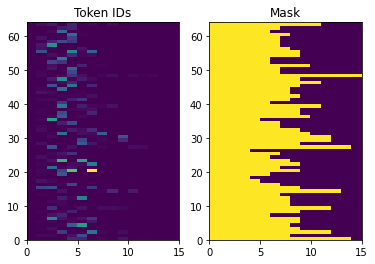

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

#The encoder

In [ ]:
embedding_dim = 256
units = 1024

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 1024)
Encoder state, shape (batch, units): (64, 1024)


#The Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights


In [ ]:
attention_layer = BahdanauAttention(units)

In [ ]:
(example_tokens != 0).shape

TensorShape([64, 15])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 15)


Text(0.5, 1.0, 'Mask')

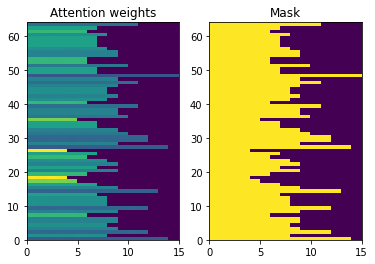

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
attention_weights.shape

TensorShape([64, 2, 15])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

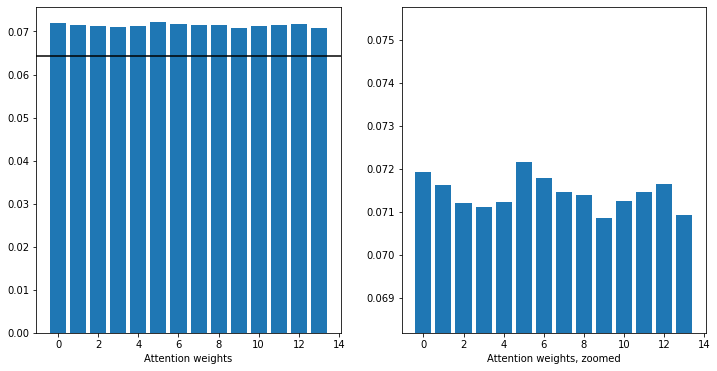

In [ ]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

#The Luong's Multiplicative Attention

In [ ]:
class LuongMultiplicativeAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()

    self.W = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.Attention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w_query = self.W(query)
    shape_checker(w_query, ('batch', 't', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w_query, value],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
luong_attention_layer = LuongMultiplicativeAttention(units)

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = luong_attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')


Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 15)


Text(0.5, 1.0, 'Mask')

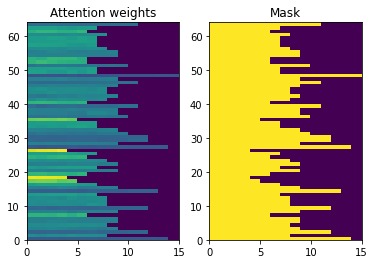

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

<Figure size 432x288 with 0 Axes>

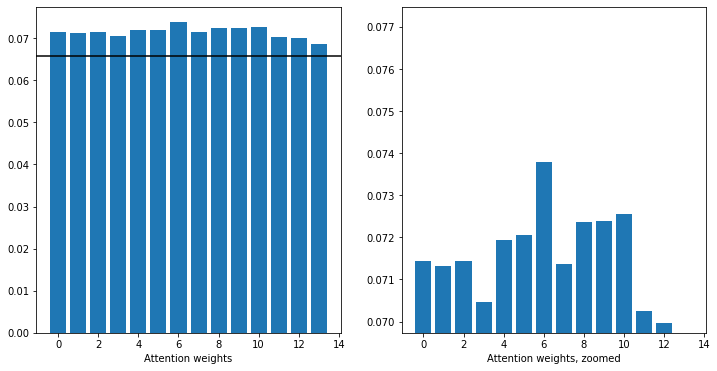

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

#The decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units, attn_type):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    if attn_type == 'Bahdanau':
      self.attention = BahdanauAttention(self.dec_units)
    elif attn_type == 'Luong':
      self.attention = LuongMultiplicativeAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units, attn_type = 'Luong')

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])


In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['late'],
       ['smaller'],
       ['represent'],
       ['essentially'],
       ['name']], dtype='<U16')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['finish'],
       ['being'],
       ['singing'],
       ['sock'],
       ['need']], dtype='<U16')

#The training

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True,
               attn_type='Luong'):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units, attn_type)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False, attn_type='Luong')

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.543531>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.511523>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4513803>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.285915>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.7396293>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9653783>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.779162>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.35029>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.989763>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8458304>}

CPU times: user 8.56 s, sys: 101 ms, total: 8.66 s
Wall time: 8.74 s


In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)


In [ ]:
TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8719647>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8776236>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.838283>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.767157>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.673425>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5755036>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5071254>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4636369>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4382663>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4086437>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3768065>}

CPU times: user 4.59 s, sys: 648 ms, total: 5.24 s
Wall time: 3.41 s


....................................................................................................


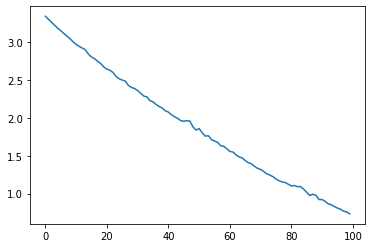

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor, attn_type='Bahdanau')

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

##Train the model with Bahdanau Attention

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
500/500 [==============================] - 226s 436ms/step - batch_loss: 3.9162
Epoch 2/3
500/500 [==============================] - 221s 441ms/step - batch_loss: 3.0257
Epoch 3/3
500/500 [==============================] - 222s 443ms/step - batch_loss: 2.5528


Text(0, 0.5, 'CE/token')

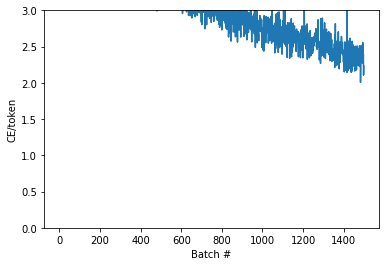

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

##Train with Luong's Attention

In [ ]:
luong_train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor, attn_type='Luong')

# Configure the loss and optimizer
luong_train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs_luong(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss_luong = BatchLogs_luong('batch_loss')

In [ ]:
luong_train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss_luong])

Epoch 1/3
500/500 [==============================] - 197s 380ms/step - batch_loss: 3.2018
Epoch 2/3
500/500 [==============================] - 190s 378ms/step - batch_loss: 1.6448
Epoch 3/3
500/500 [==============================] - 190s 379ms/step - batch_loss: 1.1628


Text(0, 0.5, 'CE/token')

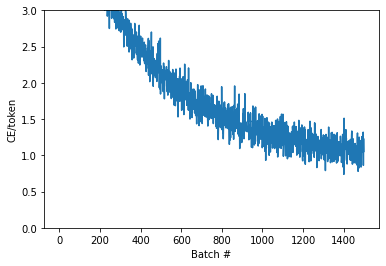

In [ ]:
plt.plot(batch_loss_luong.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

#Translate

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
luong_translator = Translator(
    encoder=luong_train_translator.encoder,
    decoder=luong_train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

##Convert token IDs to text

In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'hang compared', b'betrayed cremated', b'rome kidnapped',
       b'badly fortunate', b'colds oboe'], dtype=object)

In [ ]:

luong_translator.tokens_to_text(example_output_tokens).numpy()

array([b'prude accuracy', b'twelve names', b'wound outspoken',
       b'lunch seem', b'watered reputation'], dtype=object)

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens


In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1553],
       [1331],
       [1247],
       [4861],
       [4141]])>

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = luong_translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2127],
       [2884],
       [1534],
       [3604],
       [4986]])>

##Implement the translation loop

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


we walked every day of bus .
lets leave with such some onions .

CPU times: user 408 ms, sys: 8.63 ms, total: 417 ms
Wall time: 418 ms


In [ ]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = luong_translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


besides just direction me hated the tires .
japanese turn out of me of you .

CPU times: user 416 ms, sys: 14.9 ms, total: 430 ms
Wall time: 435 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)


CPU times: user 26.9 s, sys: 604 ms, total: 27.5 s
Wall time: 27.2 s


In [ ]:
%%time
result = luong_translator.tf_translate(
    input_text = input_text)

CPU times: user 24.9 s, sys: 469 ms, total: 25.4 s
Wall time: 25.2 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


ill try separated evil .
he spilt little the crown train .

CPU times: user 227 ms, sys: 27.7 ms, total: 255 ms
Wall time: 310 ms


In [ ]:
%%time
result = luong_translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


lets just count insulted it .
scandal suggesting arguing me me down wash me .

CPU times: user 202 ms, sys: 39.6 ms, total: 242 ms
Wall time: 294 ms


In [ ]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


they runs two months through .
they apologized watching marys opinions .

CPU times: user 349 ms, sys: 5.77 ms, total: 355 ms
Wall time: 349 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)


CPU times: user 27.2 s, sys: 487 ms, total: 27.7 s
Wall time: 27.4 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


we forgot along .
they had some experts .

CPU times: user 203 ms, sys: 38.5 ms, total: 242 ms
Wall time: 304 ms


In [ ]:
%%time
result = luong_translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

they again surprised herself when i listen .
i ordered you several me .

CPU times: user 211 ms, sys: 24.6 ms, total: 235 ms
Wall time: 291 ms


##Visualize the process

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))


[0.99999994 1.         0.99999994 1.         0.9999999  1.
 0.99999994 0.99999994 1.         1.         1.         1.0000001
 1.         0.99999994 1.         1.         1.         1.
 1.         0.99999994 1.0000001  0.9999999  0.9999999  1.0000001
 0.99999994 1.         0.99999994 1.0000001  1.         1.
 1.         0.99999994 0.9999999  1.         1.         0.9999998
 0.99999994 1.         0.99999994 1.         1.0000001  1.
 1.         1.         1.0000001  0.99999994 1.         1.0000001
 1.         1.0000001 ]


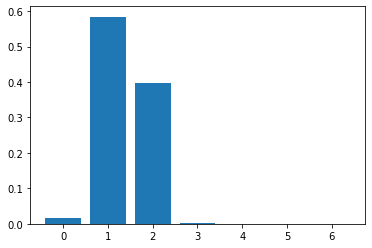

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

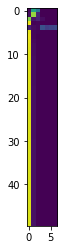

In [ ]:
plt.imshow(np.array(a), vmin=0.0, vmax=1.0)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0, vmax=1.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

###Bahdanau attention weights

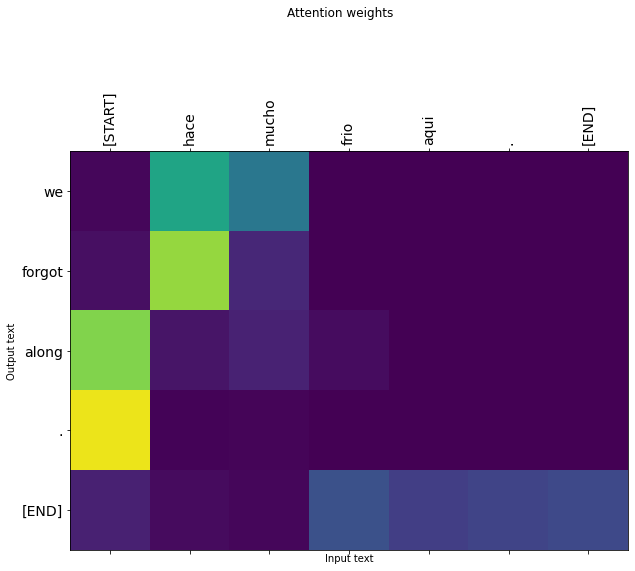

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [ ]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = luong_translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()


lets get astonished and join me half .
did you be emotional indoors ?
lets focus normally dollars yourself .

CPU times: user 211 ms, sys: 26 ms, total: 237 ms
Wall time: 297 ms


In [ ]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'take going to lock skiing .',
       b'could you play good saturday last month ?',
       b'wake it together .'], dtype=object)>

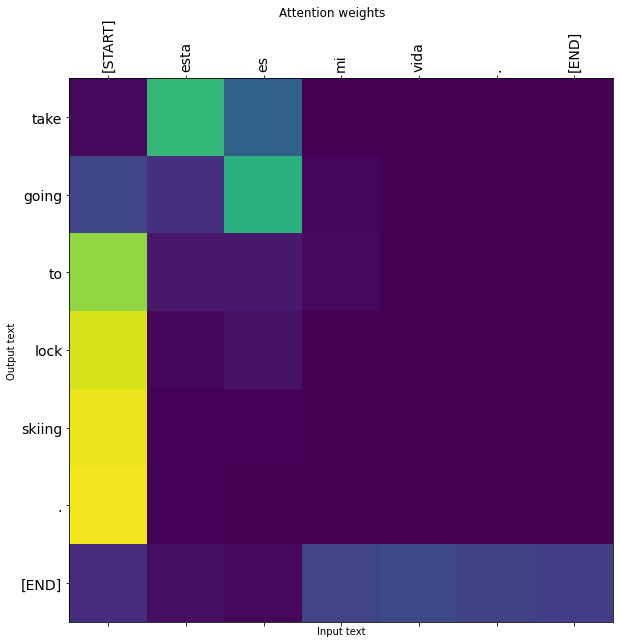

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])


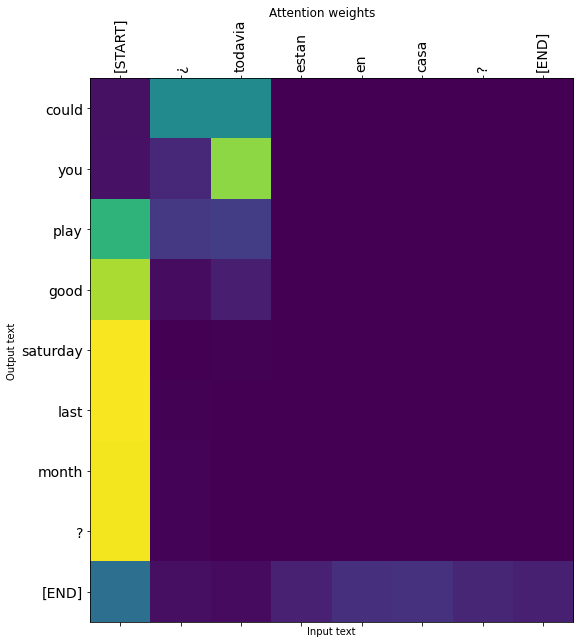

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

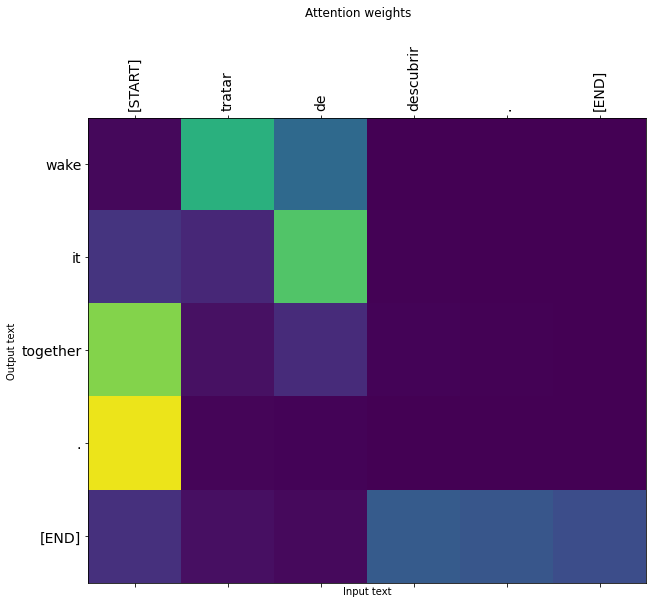

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 Doubtless there exists in this world precisely the right woman for any
given man to marry and vice versa; but when you consider that a human
being has the opportunity of being acquainted with only a few hundred
people, and out of the few hundred that there are but a dozen or less
whom he knows intimately, and out of the dozen, one or two friends at
most, it will easily be seen, when we remember the number of millions
who inhabit this world, that probably, since the earth was created,
the right man has never yet met the right woman.


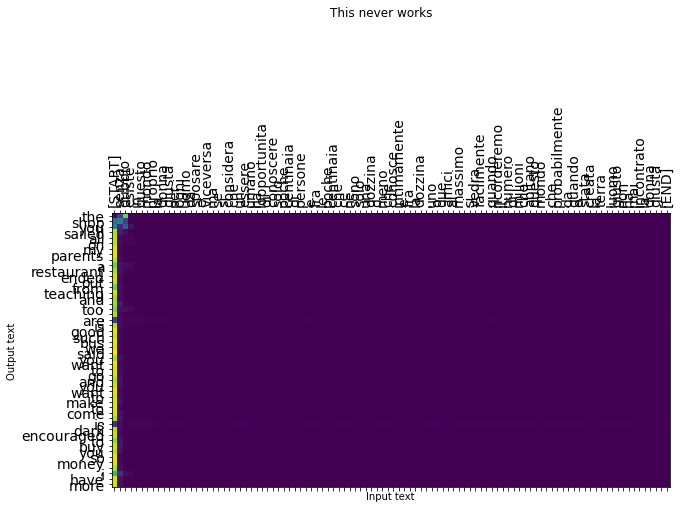

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')


###Luong's attention weights

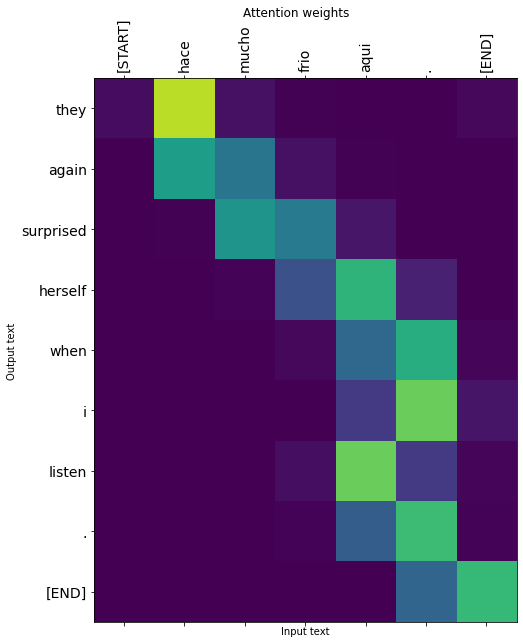

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

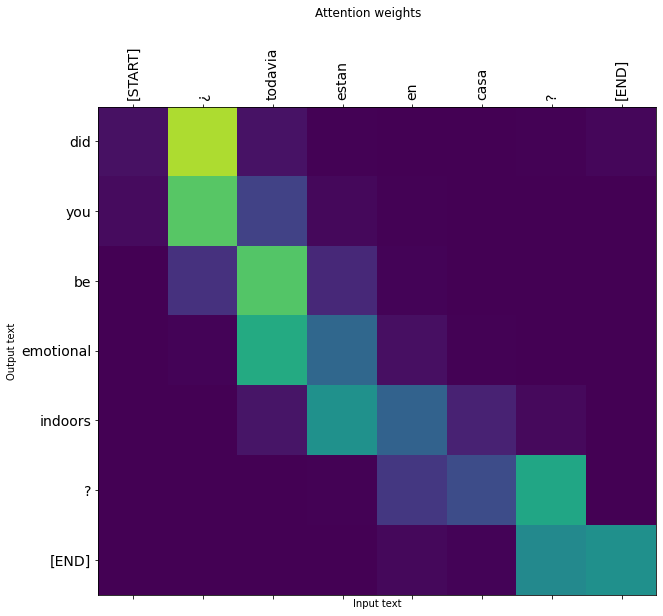

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

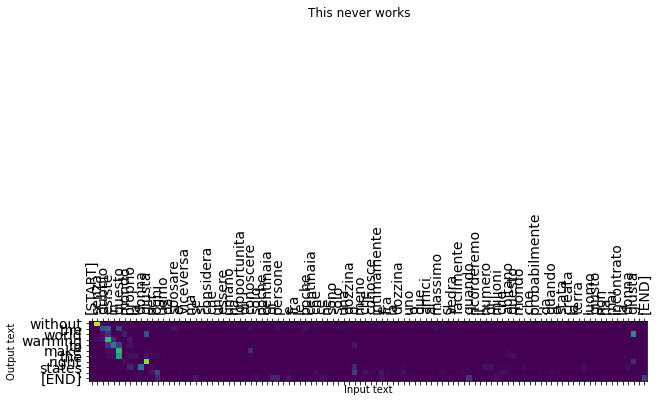

In [ ]:
result = luong_translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

#Export

In [ ]:
tf.saved_model.save(translator, '/content/drive/MyDrive/IDL_Lecture/translator',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
reloaded = tf.saved_model.load('/content/drive/MyDrive/IDL_Lecture/translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

that was not my fate .
will you sell garlic , the universe channel ?
the island are public transportation .

CPU times: user 218 ms, sys: 33.2 ms, total: 251 ms
Wall time: 312 ms


# Questions & Answers

##Do you see qualitative differences in the attention weights between different attention mechanisms?

Ans-) Yes, the Luong's Multiplicative attention performed better than Bahdanau in the second epoch and third as the loss was much less.

##Do you think that the model attends to the correct tokens in the input language (if you understand both languages)?
Ans-) No, the model learns the tokens as it is. It might be that it could learn the same meaning of the tokens because of the context.

## Q1-)Which parts of the sentence are used as a token? Each character, each word, or are some words split up?

Ans-) Each word.

## Q-2) Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?


Ans-) No. 

As example we can see below:

*  inp = 'die hallo morgen guten tag'
*  tar = 'Someone might die because of the situation'
*  inp_voc = [0 1 2 3 4 5]
*  tar_voc = [0 1 2 3 4 5 6]

## Q-3)What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state (for the architecture used in the tutorial)?

Ans-) Encoder ouput is dependent on encoder hidden state whereas vice-versa isn't the same.

## Q-4) Is the decoder attending to all previous positions, including the previous decoder predictions?

Ans-) No it will attend to just the previous decoder state and predictions

## Q-5) Does the encoder output change in different decoding steps?

Ans-) No.

## Q-6) Does the context vector change in different decoding steps?

Ans-) Yes

## Q-7) The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

Ans-) No because even the previous decoder state is also connected to the current decoder state.

## Q-8) Why is a mask applied to the loss function?

Ans-) To skip the zero padded cells in the sequences.

## Q-9) When translating the same sentence multiple times, do you get the same result? Why (not)? If not, what changes need to be made to get the same result each time?

Ans-) The output is not consistent. Make temperature == 1 to get the same output.

# References



1.   https://www.tensorflow.org/text/tutorials/nmt_with_attention
2.   https://ovgu-ailab.github.io/idl2021/ass7.html

